In [1]:
# Visualization of activity difference between a classical neural network and a FGnet
# shows that FGNs are trainable over multiple layers
# shows that FGNs have less linear seperation of space

# you can try various: Network sizes, dropout probs, lambdas in the losses, different 2d data sets

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device

torch.cuda.set_device(0)

CUDA Available:  True
Using device: cuda


In [6]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [7]:
total_num_samples = 5000

# random moons
samples1, labels1 = datasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)
# samples2, labels2 = datasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)
# samples3, labels3 = datasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)
# samples4, labels4 = datasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)

# samples2 = [-2,-2] + np.matmul(samples2, [[0,-1],[1,0]])
# samples3 = [-2,+2] + np.matmul(samples3, [[-1,0],[0,-1]])
# samples4 = [+2,-3] + np.matmul(samples4, [[0,-1],[1,0]])

# samples, labels = np.concatenate((samples1, samples2, samples3, samples4)), np.concatenate((labels1, labels2, labels3, labels4))
# samples, labels = shuffle_in_unison(samples, labels)

samples, labels = samples1, labels1

# random concentric circles
# samples, labels = datasets.make_circles(n_samples=total_num_samples, noise=0.08, factor=0.4, shuffle=True)

# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


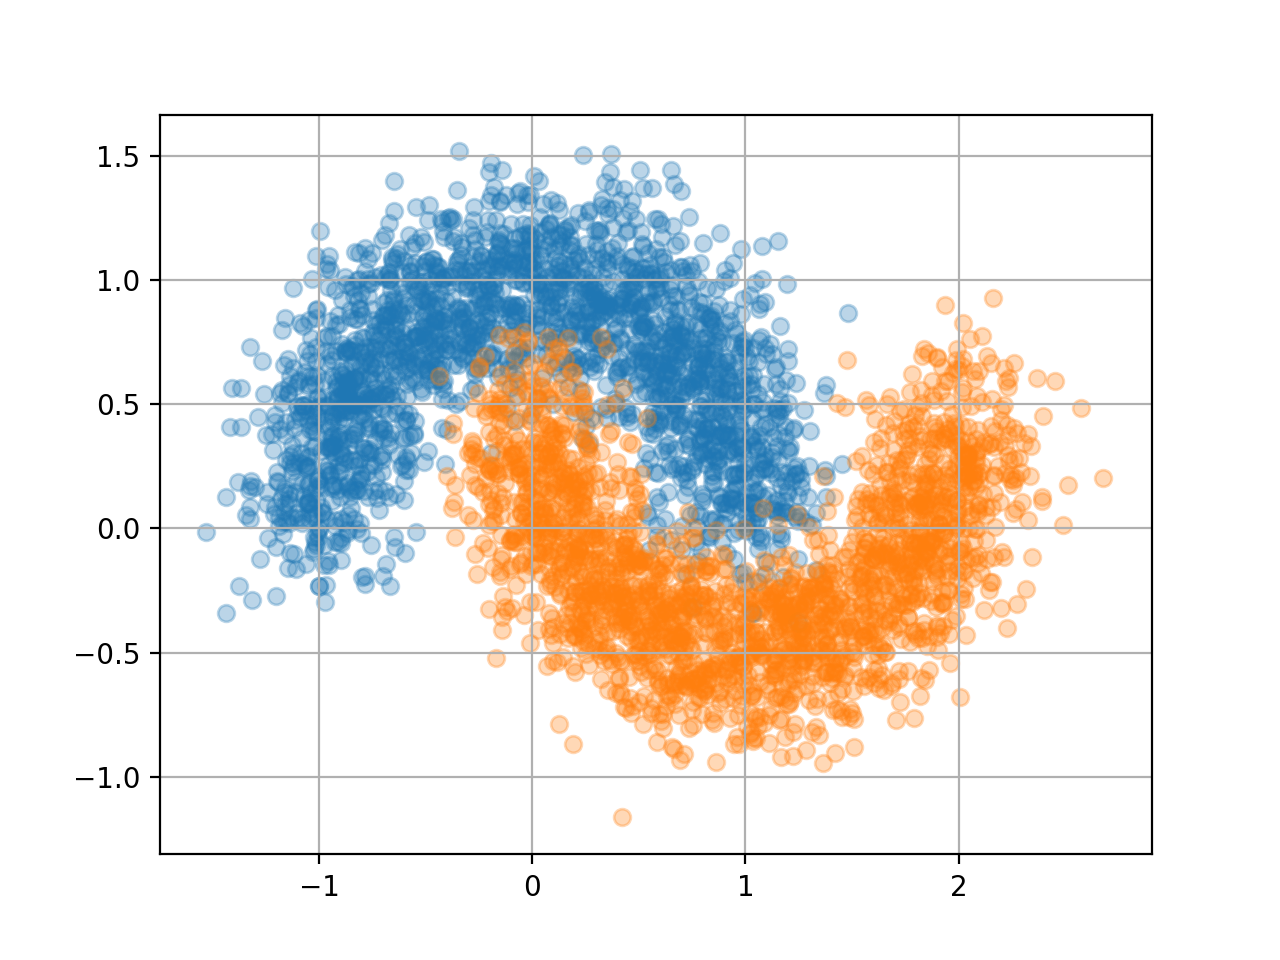

In [8]:
# 2D Check 
samples_x_1 = [x for x,l in zip(train_samples[:,0], train_labels) if l==0]
samples_y_1 = [y for y,l in zip(train_samples[:,1], train_labels) if l==0]

samples_x_2 = [x for x,l in zip(train_samples[:,0], train_labels) if l==1]
samples_y_2 = [y for y,l in zip(train_samples[:,1], train_labels) if l==1]


plt.scatter(samples_x_1, samples_y_1, alpha=0.3)
plt.scatter(samples_x_2, samples_y_2, alpha=0.3)
plt.grid(True)
plt.show()

In [9]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y, ) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, shuffle=True) # create your dataloader

In [10]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda_l2)
      
def l2_loss(model):
    # sum of w^2 for regularizer 
    for p in model.named_parameters():
        if ('weight' in p[0]) or ('bias' in p[0]):
            try:
                l2 += torch.sum(p[1]**2)
            except:
                l2 = torch.sum(p[1]**2)          
    return l2


def classical_cross_ent_loss(model, output, target):
    cent_loss = F.cross_entropy(output, target.long())
    l2 = l2_loss(model)
    return cent_loss + lmbda_l2*l2

0.0001


In [11]:
# Initialize the classic network
hidden_l_nums = [8,8,8]
drop_p = 0.1
classic_model = fgnl.Feedforward_Classic_net(in_feats=2, out_feats=2, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

In [12]:
classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()),momentum=0.5)

In [13]:
epochs = 50
classic_train_res = fgnh.train(classic_model, device, my_dataloader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.3470, Accuracy: 3397/4000 (85%)
Test set - Average loss: 0.2010, Accuracy: 923/1000 (92%)
Epoch 1 Train set - Average loss: 0.2991, Accuracy: 3504/4000 (88%)
Test set - Average loss: 0.2054, Accuracy: 933/1000 (93%)
Epoch 2 Train set - Average loss: 0.2709, Accuracy: 3548/4000 (89%)
Test set - Average loss: 0.1806, Accuracy: 936/1000 (94%)
Epoch 3 Train set - Average loss: 0.2774, Accuracy: 3516/4000 (88%)
Test set - Average loss: 0.1686, Accuracy: 943/1000 (94%)
Epoch 4 Train set - Average loss: 0.2634, Accuracy: 3576/4000 (89%)
Test set - Average loss: 0.1923, Accuracy: 946/1000 (95%)
Epoch 5 Train set - Average loss: 0.2761, Accuracy: 3536/4000 (88%)
Test set - Average loss: 0.1745, Accuracy: 944/1000 (94%)
Epoch 6 Train set - Average loss: 0.2697, Accuracy: 3547/4000 (89%)
Test set - Average loss: 0.1522, Accuracy: 957/1000 (96%)
Epoch 7 Train set - Average loss: 0.2637, Accuracy: 3579/4000 (89%)
Test set - Average loss: 0.2111, Accuracy: 935/100

In [14]:
# scale of the heat maps
X1 = np.arange(-10.0, 10.01, 0.1)
X1s, X2s = np.meshgrid(X1,X1)
heatmap_inputs = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
print("shape of heatmap", np.shape(heatmap_inputs))
heatmap_inputs = torch.Tensor(heatmap_inputs)
print(type(heatmap_inputs))
# print(heatmap_inputs)

shape of heatmap (40401, 2)
<class 'torch.Tensor'>


In [15]:
# compute predictions
classic_heatmap_preds = classic_model(heatmap_inputs.to(device))
classic_heatmap_preds = classic_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
classic_heatmap_preds = np.array([np.exp(x)/sum(np.exp(x)) for x in classic_heatmap_preds])

<IPython.core.display.Javascript object>


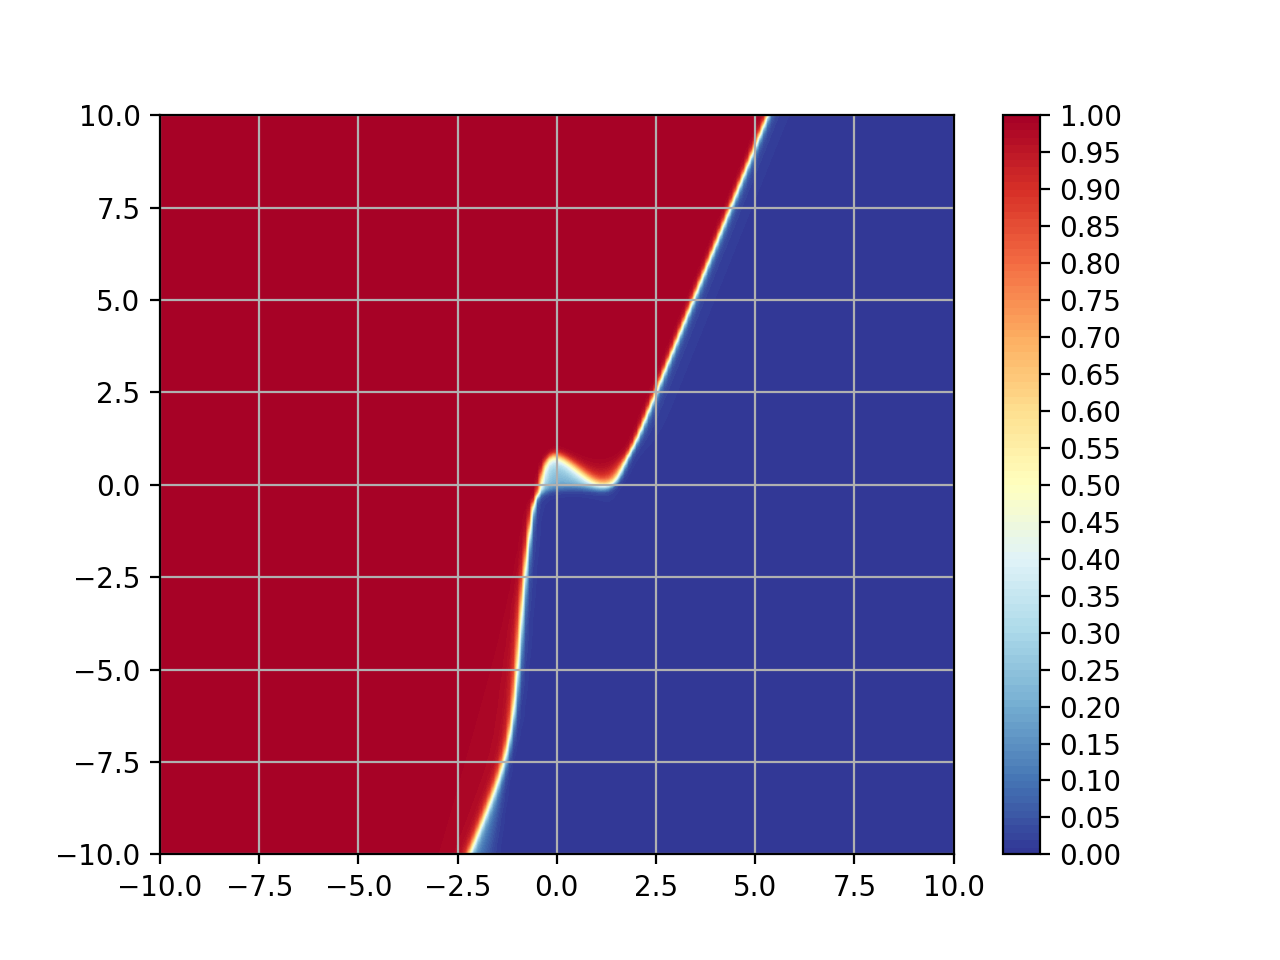

In [16]:
levels = np.arange(-0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(classic_heatmap_preds[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
plt.colorbar(ticks=ticks)

# plt.scatter(samples_x_1, samples_y_1, alpha=0.2, c='black')
# plt.scatter(samples_x_2, samples_y_2, alpha=0.2, c='black')

plt.grid(True)
plt.show()

In [17]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 100.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

# loss functions
def sigmas_loss(model):
    # sum of sigma^2 for regularizer 
    for p in model.named_parameters():
        if 'sigs' in p[0]:
            try:
                sig_loss += torch.sum(p[1]**2)
            except:
                sig_loss = torch.sum(p[1]**2)
                
    return sig_loss


def fgn_cross_ent_loss(model, output, target):
    
    # normal Cent loss
    cent_loss = F.cross_entropy(output, target.long())
    # normal l2 loss
    l2 = l2_loss(model)
    #sigma loss
    sig_loss = sigmas_loss(model)
    
    return cent_loss + lmbda_l2*l2 + lmbda_sigs*sig_loss


lambda for l2 loss 0.0001
lambda for sigs^2 loss 0.01


In [18]:
# Initialize the fgn network
print("hidden layers:", hidden_l_nums)
print("drop prob:", drop_p)
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

hidden layers: [8, 8, 8]
drop prob: 0.1


In [19]:
fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()),momentum=0.5)

In [20]:
fgn_train_res = fgnh.train(fgn_model, device, my_dataloader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.8302, Accuracy: 3438/4000 (86%)
Test set - Average loss: 0.6497, Accuracy: 619/1000 (62%)
Epoch 1 Train set - Average loss: 0.5104, Accuracy: 3534/4000 (88%)
Test set - Average loss: 0.5139, Accuracy: 900/1000 (90%)
Epoch 2 Train set - Average loss: 0.4702, Accuracy: 3538/4000 (88%)
Test set - Average loss: 0.4103, Accuracy: 941/1000 (94%)
Epoch 3 Train set - Average loss: 0.4312, Accuracy: 3545/4000 (89%)
Test set - Average loss: 0.4110, Accuracy: 960/1000 (96%)
Epoch 4 Train set - Average loss: 0.4359, Accuracy: 3525/4000 (88%)
Test set - Average loss: 0.4380, Accuracy: 958/1000 (96%)
Epoch 5 Train set - Average loss: 0.4122, Accuracy: 3570/4000 (89%)
Test set - Average loss: 0.3440, Accuracy: 944/1000 (94%)
Epoch 6 Train set - Average loss: 0.4174, Accuracy: 3548/4000 (89%)
Test set - Average loss: 0.2478, Accuracy: 952/1000 (95%)
Epoch 7 Train set - Average loss: 0.4098, Accuracy: 3511/4000 (88%)
Test set - Average loss: 0.3388, Accuracy: 938/100

In [21]:
# scale of the heat maps
X1 = np.arange(-10,10.01, 0.1)
X1s, X2s = np.meshgrid(X1,X1)
heatmap_inputs = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
print("shape of heatmap", np.shape(heatmap_inputs))
heatmap_inputs = torch.Tensor(heatmap_inputs)
print(type(heatmap_inputs))
# print(heatmap_inputs)

# compute predictions
fgn_heatmap_preds = fgn_model(heatmap_inputs.to(device))
fgn_heatmap_preds=fgn_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
fgn_heatmap_preds = np.array([np.exp(x)/sum(np.exp(x)) for x in fgn_heatmap_preds.astype('float128')])

shape of heatmap (40401, 2)
<class 'torch.Tensor'>


<IPython.core.display.Javascript object>


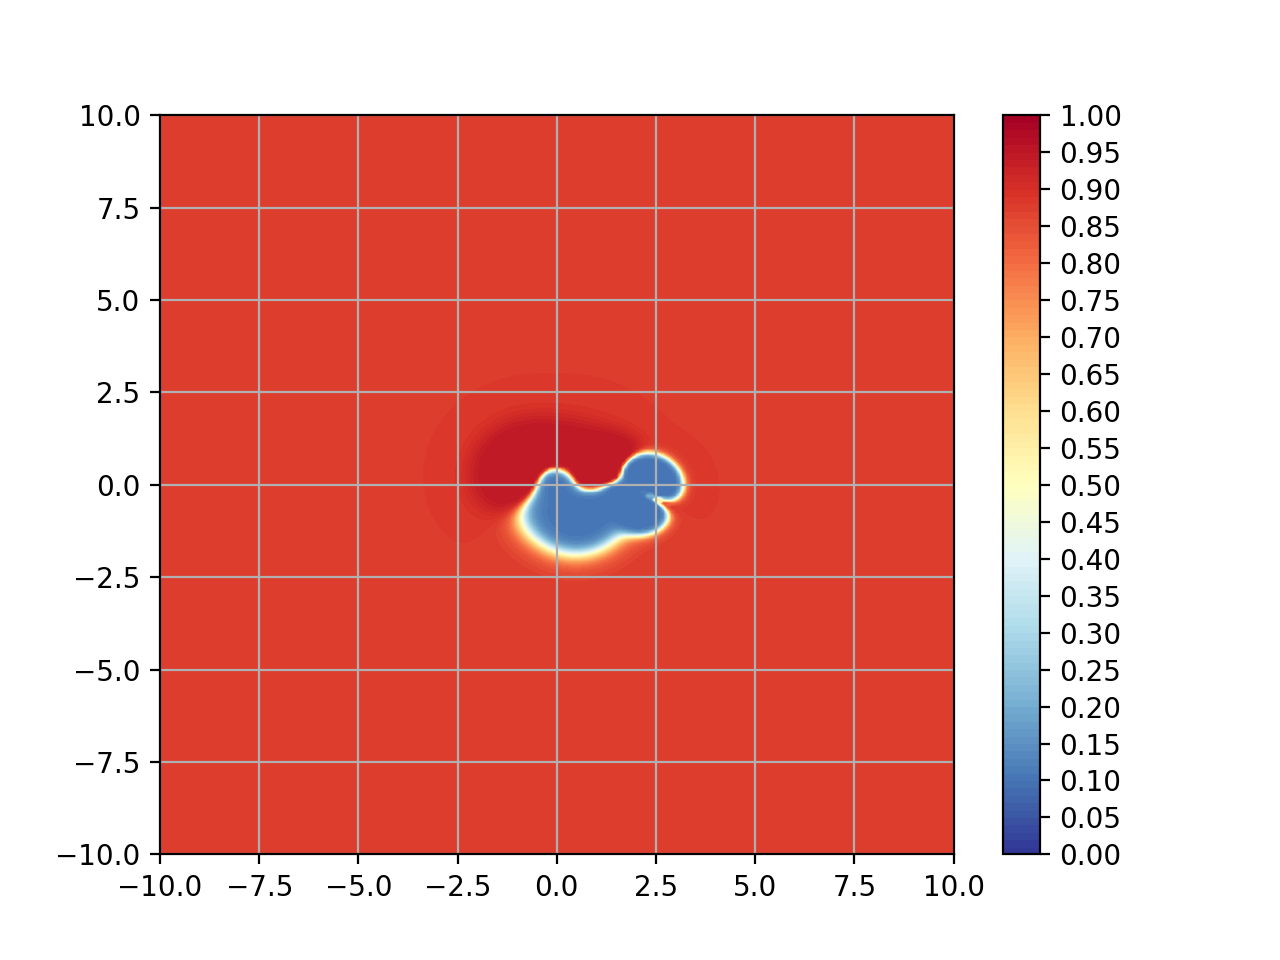

In [22]:
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

plt.contourf(X1s, X2s, np.reshape(fgn_heatmap_preds[:,0], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
plt.colorbar(ticks=ticks)

# plt.scatter(samples_x_1, samples_y_1, alpha=0.2, c='black')
# plt.scatter(samples_x_2, samples_y_2, alpha=0.2, c='black')

plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


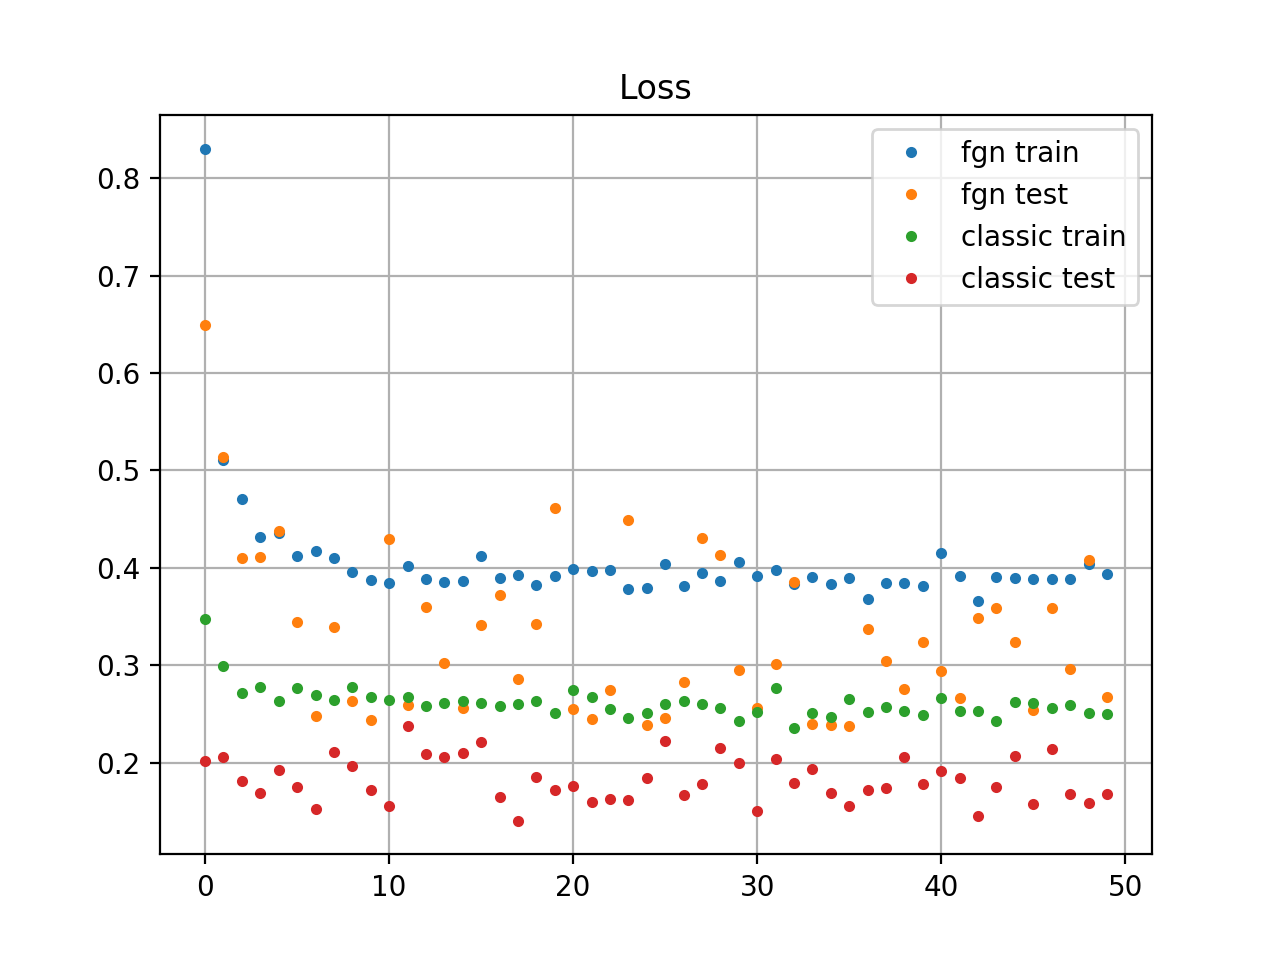

<IPython.core.display.Javascript object>


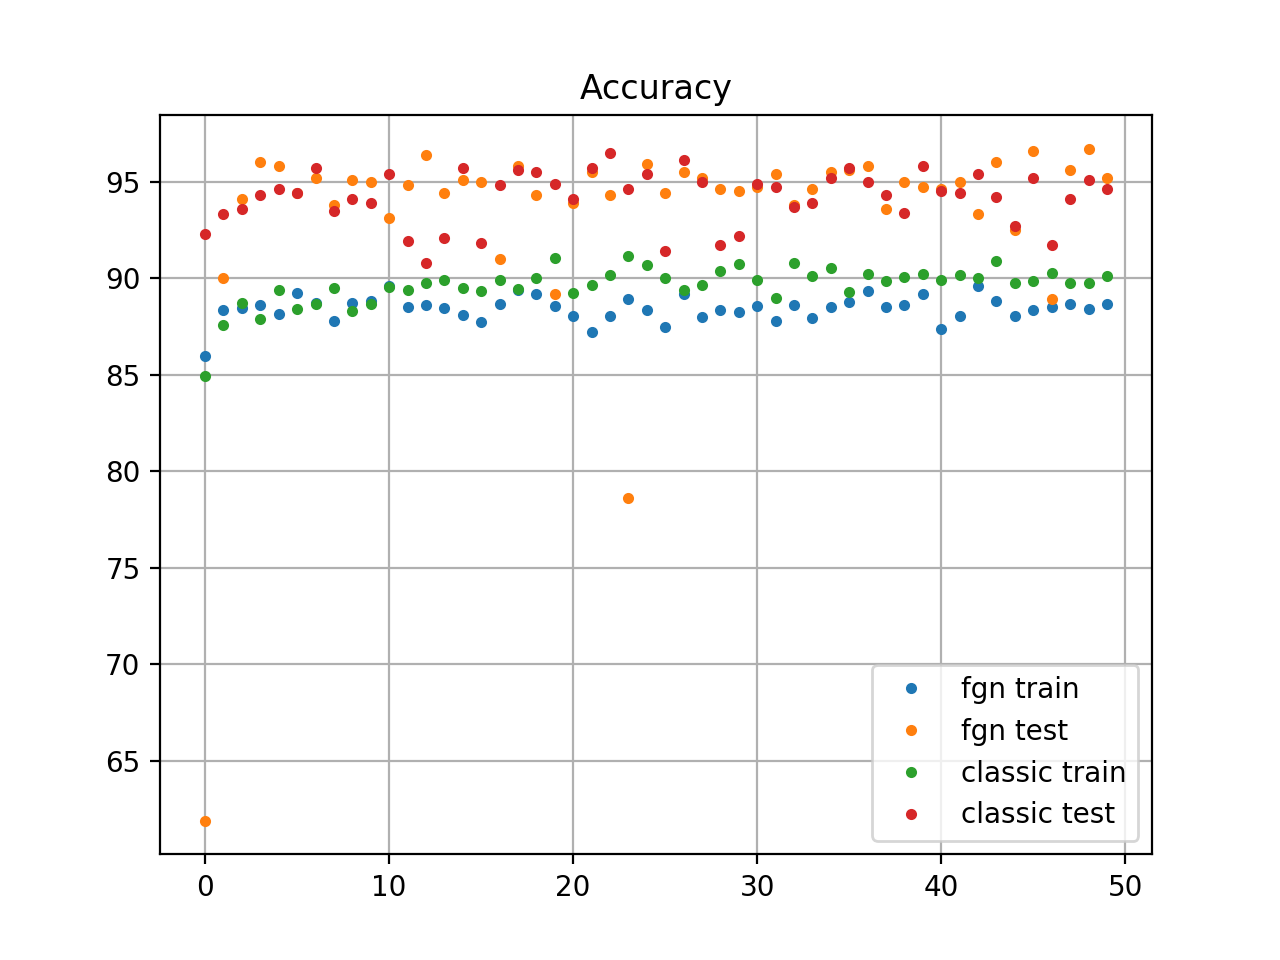

In [23]:
# acc and loss hist
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.plot(classic_train_res['train_loss_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_loss_hist'], marker='.', linestyle=' ', label='classic test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.plot(classic_train_res['train_acc_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_acc_hist'], marker='.', linestyle=' ', label='classic test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

hidden_layers.6.centers
plotting neurons: [6 3]


<IPython.core.display.Javascript object>


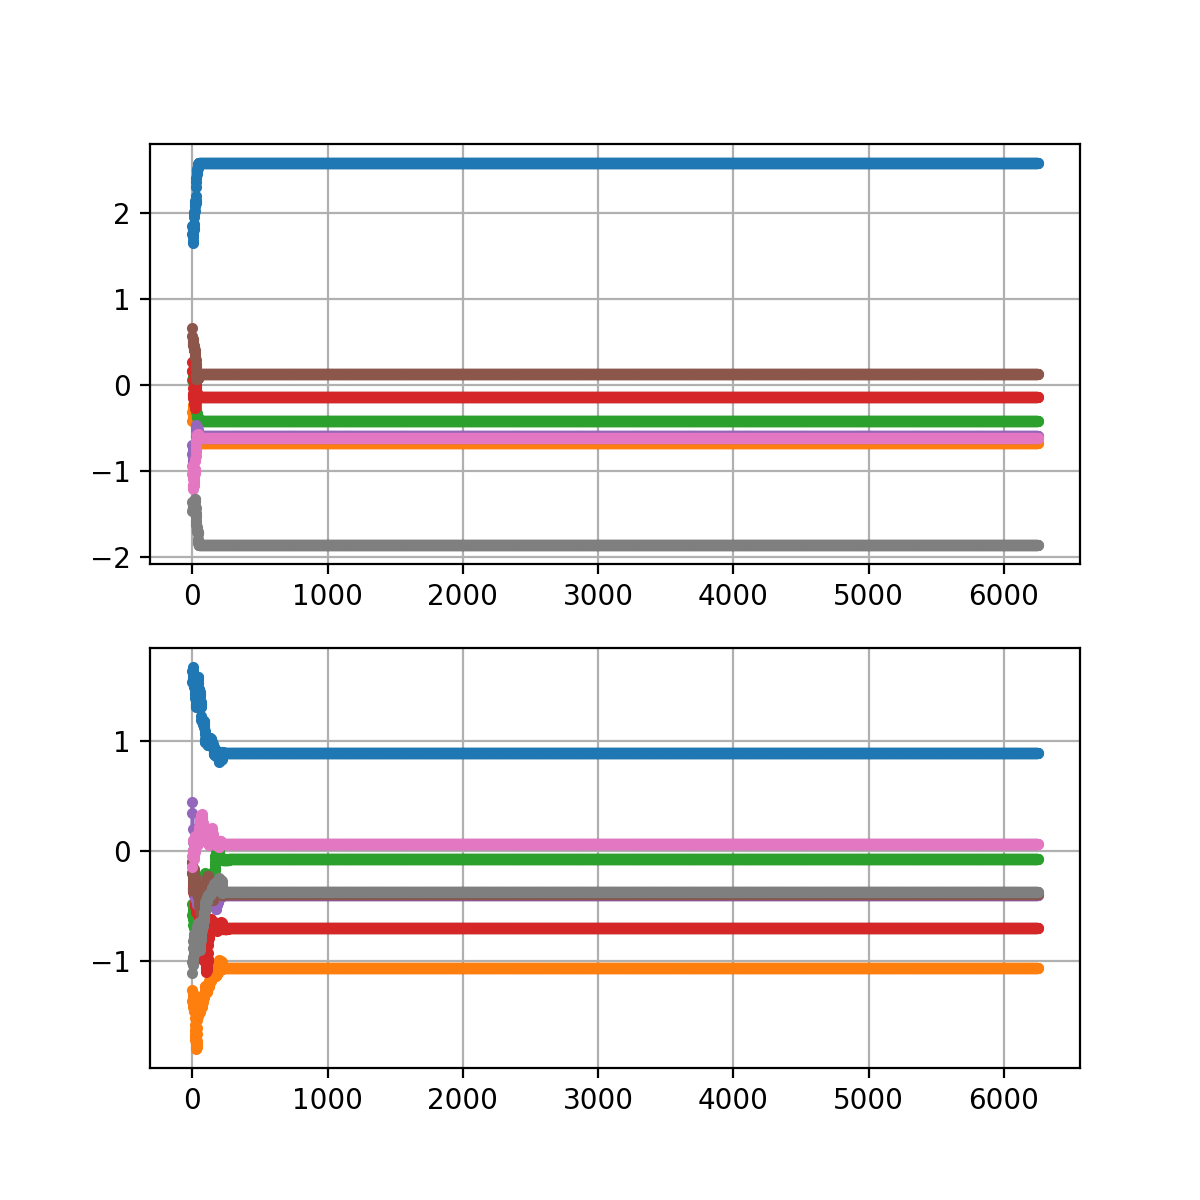

hidden_layers.3.centers
plotting neurons: [1 0]


<IPython.core.display.Javascript object>


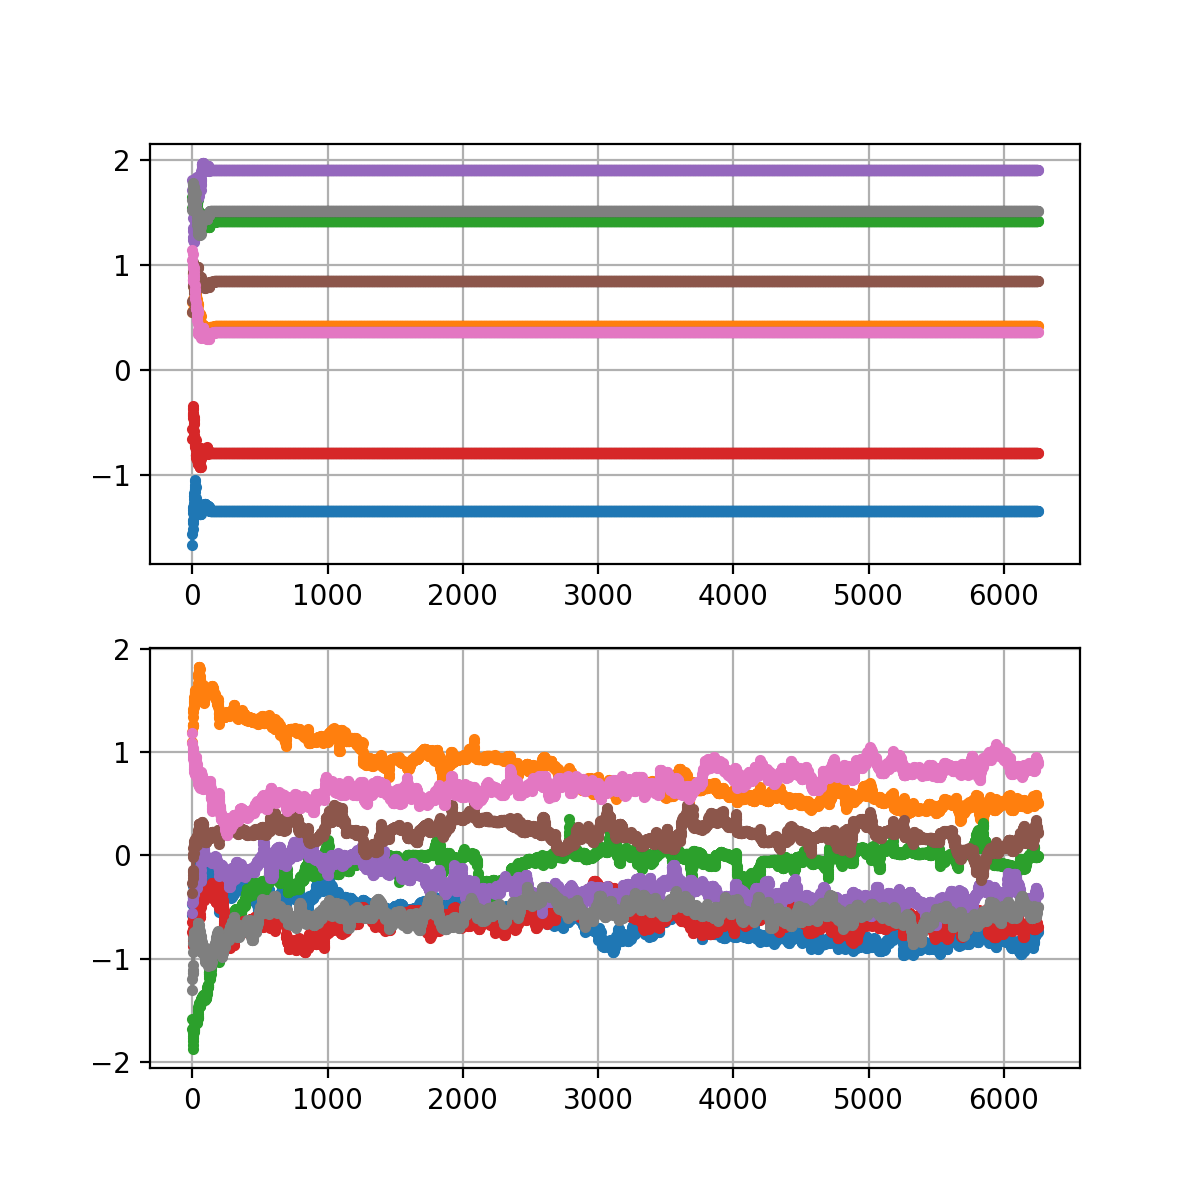

fl.centers
plotting neurons: [1 0]


<IPython.core.display.Javascript object>


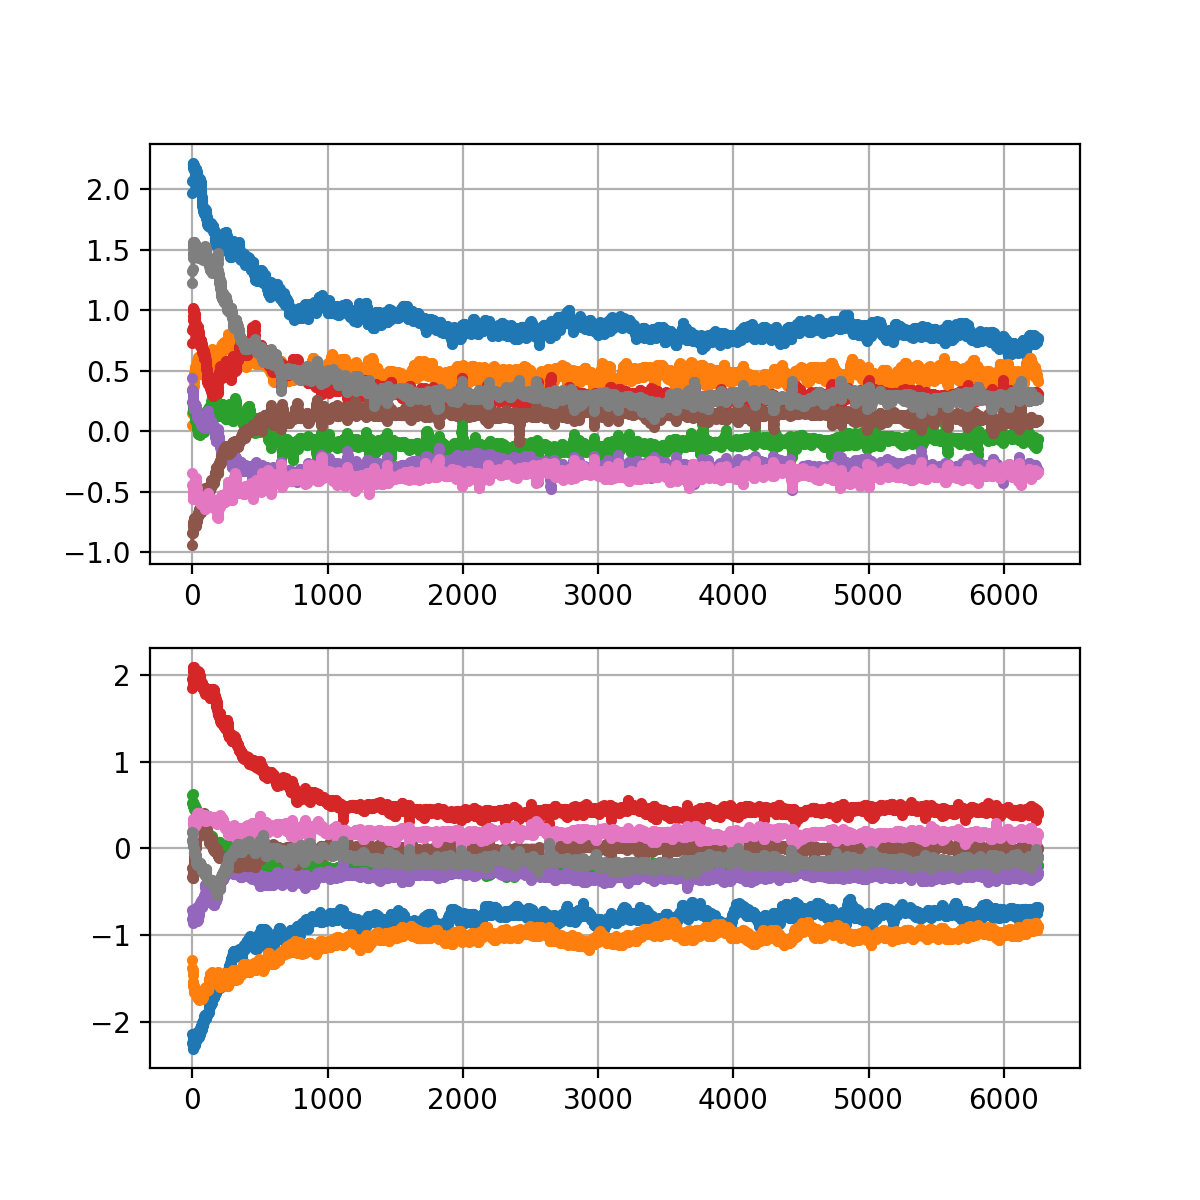

hidden_layers.0.centers
plotting neurons: [1 4]


<IPython.core.display.Javascript object>


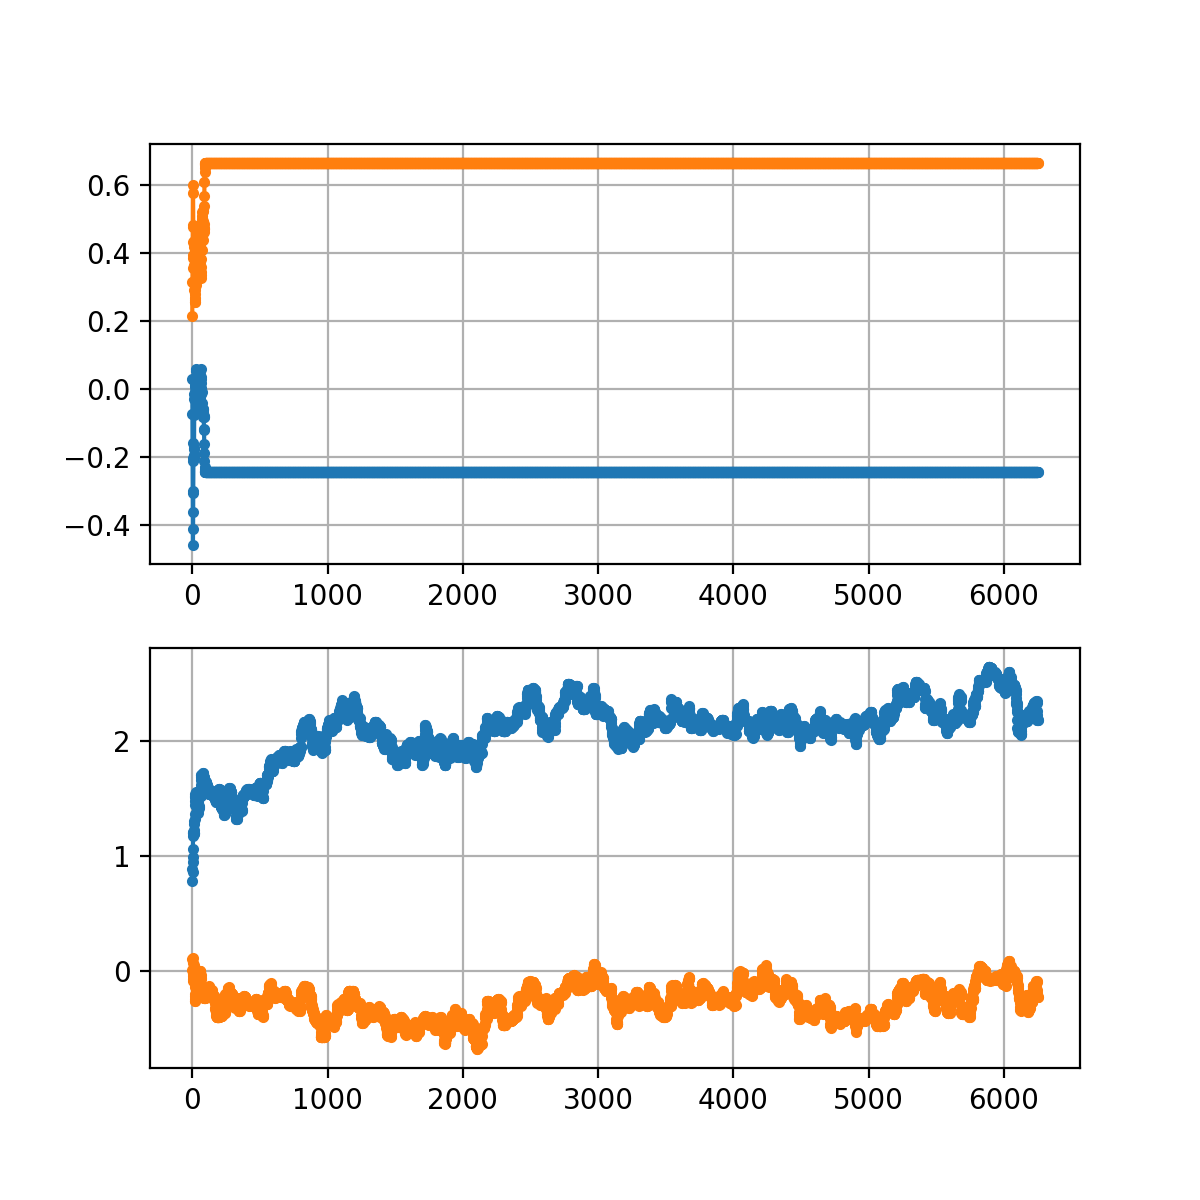

In [24]:
# plot centers history for only some hidden layer neuron

for k in fgn_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(fgn_train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = fgn_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()
            
            

hidden_layers.3.sigs


<IPython.core.display.Javascript object>


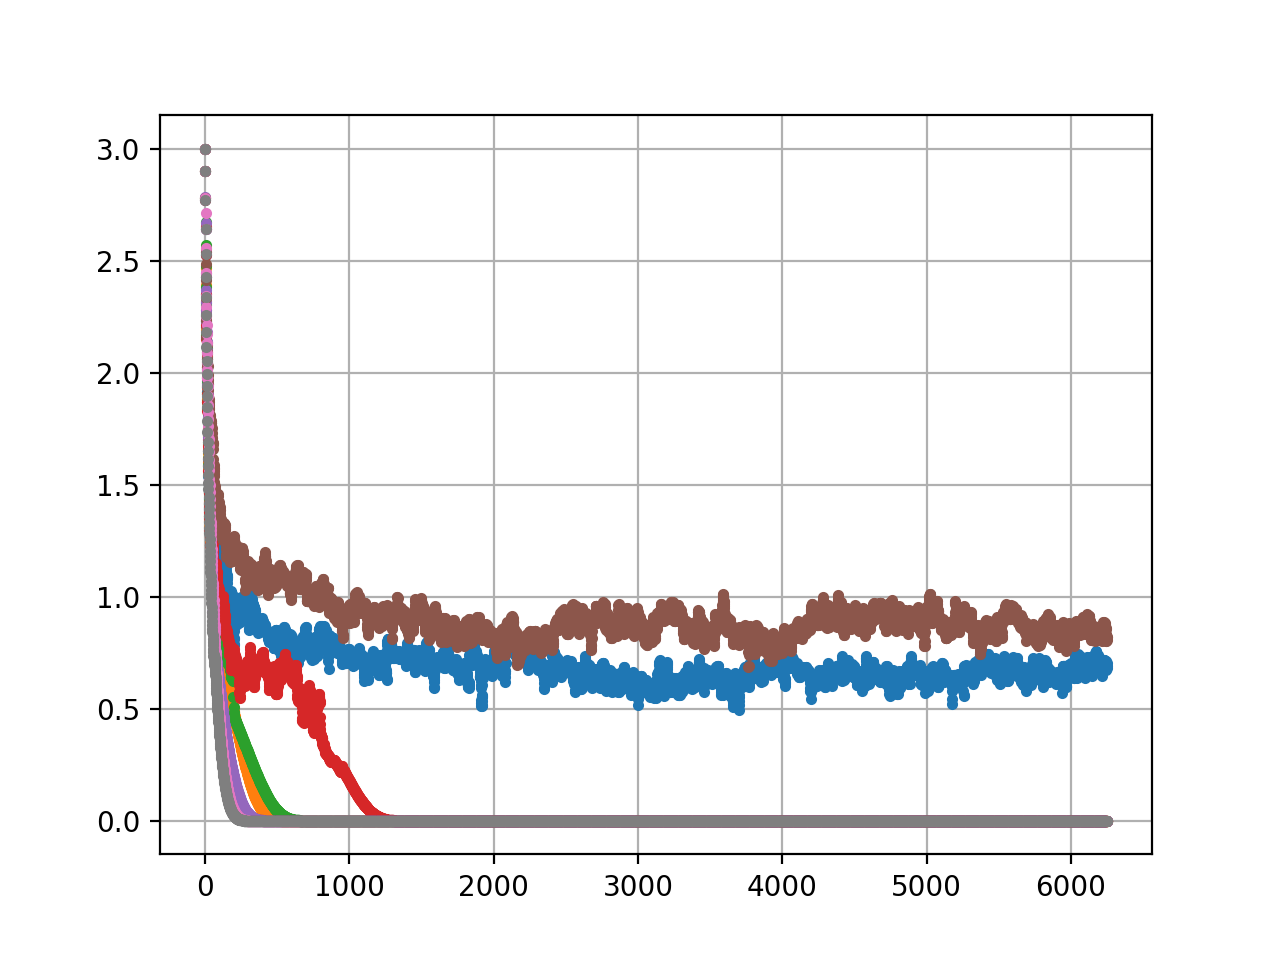

hidden_layers.6.sigs


<IPython.core.display.Javascript object>


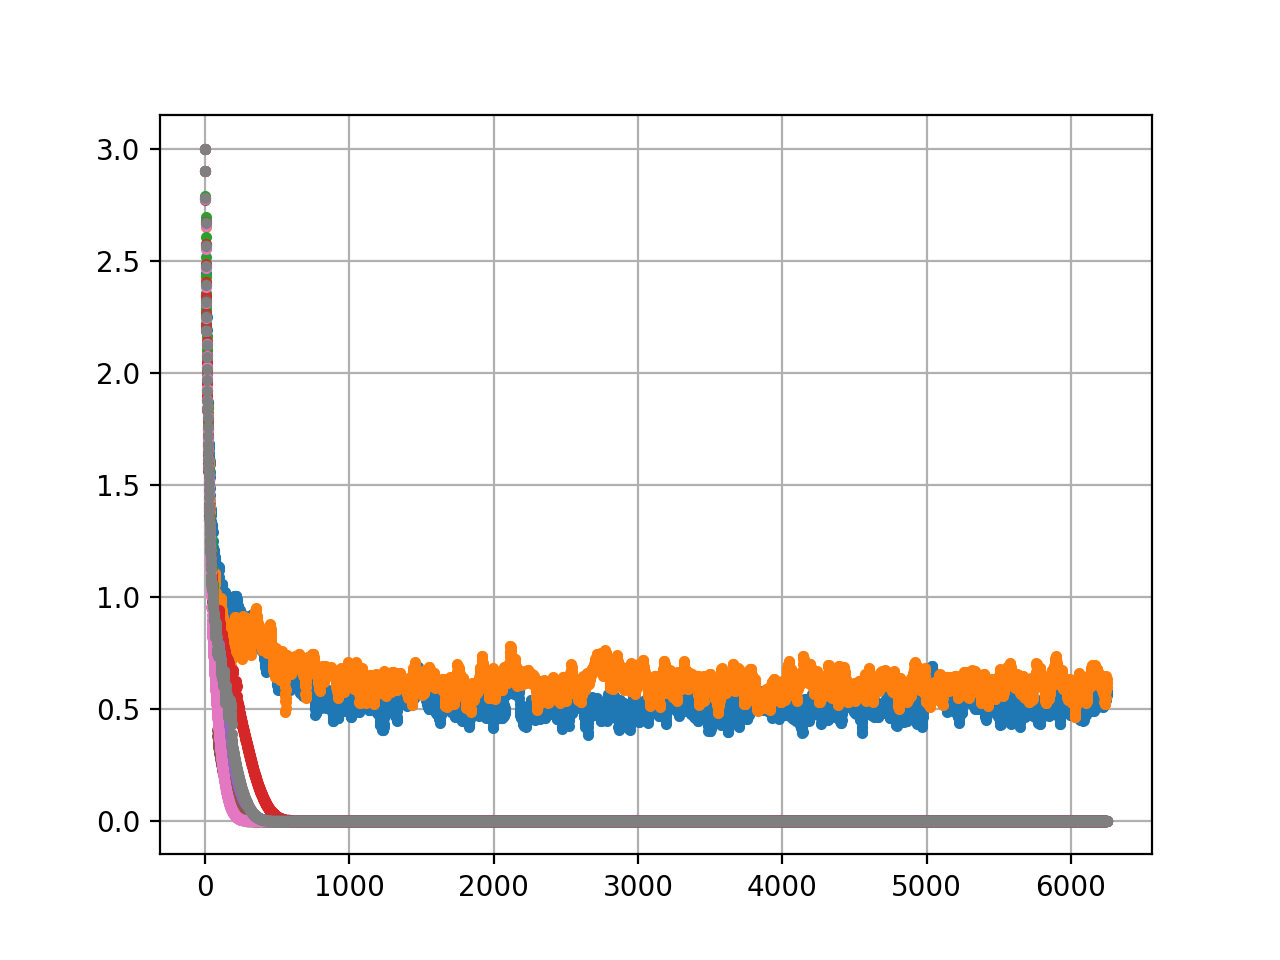

hidden_layers.0.sigs


<IPython.core.display.Javascript object>


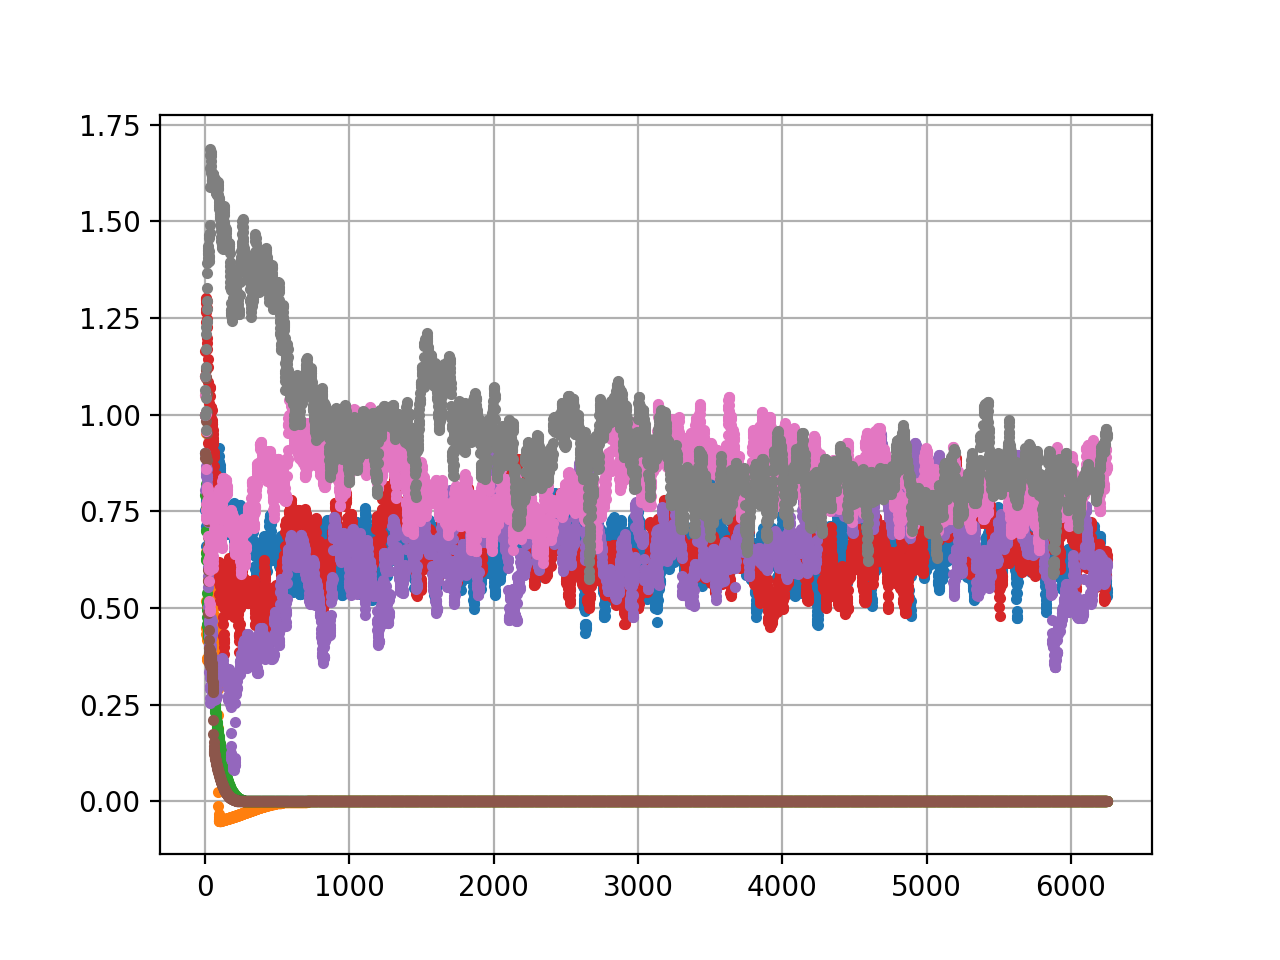

fl.sigs


<IPython.core.display.Javascript object>


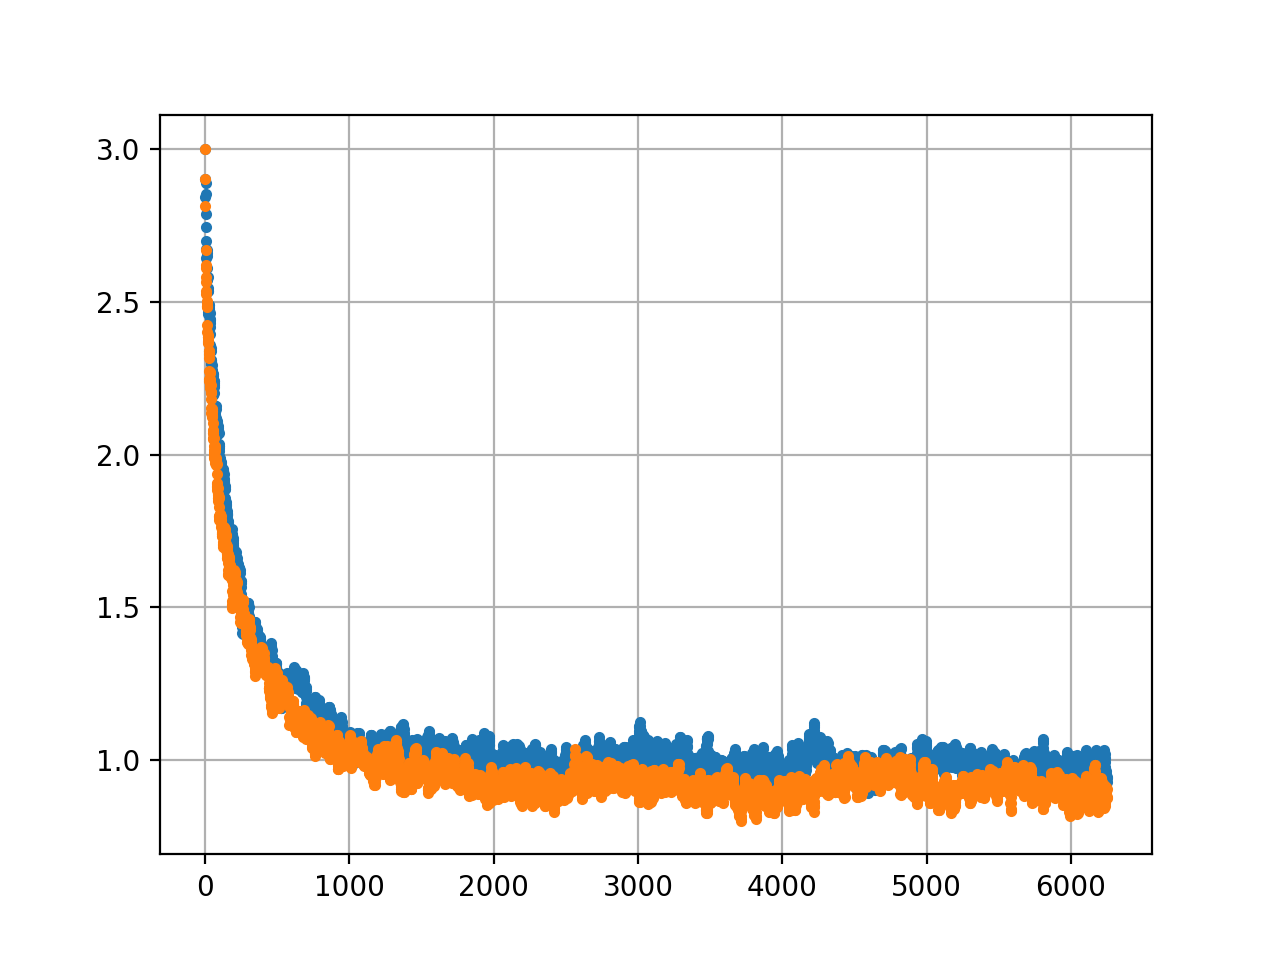

In [25]:
# check that sigma has shrunk
# plot sigma history
for k in fgn_train_res['histories'].keys():
    if 'sigs' in k:
        print(k)
        for i in range(len(fgn_train_res['histories'][k][0])):
            plt.plot(fgn_train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()